ссылка на датасет: https://disk.yandex.com/i/USHWZI3TNfAsTA

Хотел бы сразу пояснить, что задачу, которая вероятно должна была решаться кластеризацией у меня решить не получилось. Я попробовал решить алгоритмом K-means, разделив выборку на 3 кластера по landing_page, однако трудность заключалась в том, что признаки категориальные (с количественными я решал подобные задачи), а логики в попытках их закодировать encoder-ами и визуализировать с помощью pairplot я не нашел. И даже при удавшейся кластеризации, на мой взляд ее успешность можно проверить А/Б тестами, но не на исторических данных.

В итоге, ниже я проанализировал данные, создал модель классификации (предсказание зарегистрировался или нет) и попробовал выяснить с какой вероятностью пользователь зарегестрировался бы используя тот или иной лэндиндинг, на основе чего и выдавал рекомендации.  

Делал я это задание около 8 часов, + в выходные хоть и не имел под рукой компьютера, часто обдумывал возможные варианты решения. 
Хоть я и не удовлетворен ее решением, данная задача мне особенно понравилась, т.к. в целом задачи на создачу рекомендательных систем мне интересны. А в этой еще и столкнулся со сложностями, описанными выше, которые не удалось решить сходу, но буду продолжать это делать.

Был бы рад услышать советы как решать подобные задачи и ответить на ваши вопросы.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [2]:
df = pd.read_excel("Landing Page Data.xlsx")
df

,landing_page,user_id,show_date_time,browser_version,browser,os_name,country
0,lpceuwottvq4,NaN,2015-02-01 00:00:46,39.0.2171.65,Chrome,Windows,CZ
1,lpceuwottvq4,NaN,2015-02-01 00:04:30,NaN,AndroidBrowser,Linux,DE
2,lpceuwottvq4,NaN,2015-02-01 00:08:53,11.0,Microsoft Internet Explorer,Windows,GB
3,lpceuwottvq4,NaN,2015-02-01 00:28:59,40.0.2214.94,Chrome,Windows,PL
4,lpceuwottvq4,NaN,2015-02-01 00:29:11,11.0,Microsoft Internet Explorer,Windows,FR
...,...,...,...,...,...,...,...
15461,lpceuwottvq4,526736398.0,2015-02-28 22:55:39,33.0,Firefox,Windows,DE
15462,na-carnival-info-page,NaN,2015-02-28 23:06:38,40.0.2214.115,Chrome,Windows,TR
15463,lpceuwottvq4,NaN,2015-02-28 23:34:32,27.0.1689.76,Opera,Windows,EU
15464,lpceuwottvq4,526736924.0,2015-02-28 23:37:24,40.0.2214.115,Chrome,Windows,TR


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15466 entries, 0 to 15465
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   landing_page     15466 non-null  object        
 1   user_id          2192 non-null   float64       
 2   show_date_time   15466 non-null  datetime64[ns]
 3   browser_version  14698 non-null  object        
 4   browser          15314 non-null  object        
 5   os_name          15188 non-null  object        
 6   country          15466 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 845.9+ KB


In [4]:
category = ['landing_page', 'browser', 'os_name', 'country']
for c in category:
   display(df[c].value_counts())

lpceuwottvq4             12400
woteutvsupport            2392
na-carnival-info-page      674
Name: landing_page, dtype: int64

Chrome                         6981
Firefox                        3907
Microsoft Internet Explorer    2821
AndroidBrowser                  538
Safari                          456
Opera                           447
GoogleBot                        83
BingBot                          51
ChromeiOS                        24
Opera Mobile                      2
NintendoBrowser                   2
SeaMonkey                         2
Name: browser, dtype: int64

Windows          13342
Linux             1225
iOS                320
Macintosh          229
PlayStation         28
Windows Phone       24
ChromeOS            20
Name: os_name, dtype: int64

DE    2734
PL    2478
TR    2109
FR    1862
FI     998
      ... 
VE       1
HT       1
PY       1
LV       1
HN       1
Name: country, Length: 74, dtype: int64

In [5]:
print("Показатель текущей конверсии:", round(sum(~df['user_id'].isna()) / len(df), 3))

Показатель текущей конверсии: 0.142


In [6]:
data = df.copy()

In [7]:
data['user_id'] = (~data['user_id'].isna()).astype('int8')

In [8]:
data['show_date_time'].min()

Timestamp('2015-02-01 00:00:46')

In [9]:
data['show_date_time'].max()

Timestamp('2015-02-28 23:45:31')

In [10]:
# try is_weekend
data['weekday'] = data['show_date_time'].dt.weekday
data['hour'] = data['show_date_time'].dt.hour
data['weekday'].value_counts()

5    2721
6    2623
4    2204
1    2115
2    1995
0    1987
3    1821
Name: weekday, dtype: int64

<AxesSubplot:title={'center':'распределение по дням недели'}, ylabel='Frequency'>

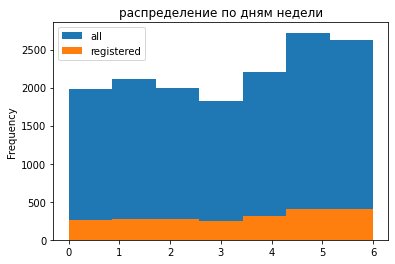

In [11]:
data["weekday"].plot(kind="hist", bins=7, label="all", legend="q")
data[data['user_id']==1]["weekday"].plot(kind="hist", bins=7, title="распределение по дням недели", label="registered", legend="q")

<AxesSubplot:title={'center':'распределение по часам'}, ylabel='Frequency'>

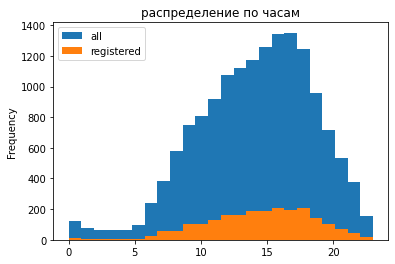

In [12]:
data["hour"].plot(kind="hist", bins=24, label="all", legend="q")
data[data['user_id']==1]["hour"].plot(kind="hist", bins=24, title="распределение по часам", label="registered", legend="q")

In [13]:
data

,landing_page,user_id,show_date_time,browser_version,browser,os_name,country,weekday,hour
0,lpceuwottvq4,0,2015-02-01 00:00:46,39.0.2171.65,Chrome,Windows,CZ,6,0
1,lpceuwottvq4,0,2015-02-01 00:04:30,NaN,AndroidBrowser,Linux,DE,6,0
2,lpceuwottvq4,0,2015-02-01 00:08:53,11.0,Microsoft Internet Explorer,Windows,GB,6,0
3,lpceuwottvq4,0,2015-02-01 00:28:59,40.0.2214.94,Chrome,Windows,PL,6,0
4,lpceuwottvq4,0,2015-02-01 00:29:11,11.0,Microsoft Internet Explorer,Windows,FR,6,0
...,...,...,...,...,...,...,...,...,...
15461,lpceuwottvq4,1,2015-02-28 22:55:39,33.0,Firefox,Windows,DE,5,22
15462,na-carnival-info-page,0,2015-02-28 23:06:38,40.0.2214.115,Chrome,Windows,TR,5,23
15463,lpceuwottvq4,0,2015-02-28 23:34:32,27.0.1689.76,Opera,Windows,EU,5,23
15464,lpceuwottvq4,1,2015-02-28 23:37:24,40.0.2214.115,Chrome,Windows,TR,5,23


In [14]:
data['browser_version'].value_counts()

35.0             3178
40.0.2214.111    2750
11.0             1933
40.0.2214.115    1541
40.0.2214.94      668
                 ... 
7.0.4               1
13.0.782.1          1
32.0.1700.99        1
6.0.466.0           1
7.2.1.0             1
Name: browser_version, Length: 314, dtype: int64

In [15]:
data['landing_page'].value_counts()

lpceuwottvq4             12400
woteutvsupport            2392
na-carnival-info-page      674
Name: landing_page, dtype: int64

In [16]:
data[data['user_id']==1]['landing_page'].value_counts()

lpceuwottvq4      1780
woteutvsupport     412
Name: landing_page, dtype: int64

In [17]:
data[data['country']=='US']

,landing_page,user_id,show_date_time,browser_version,browser,os_name,country,weekday,hour
6,lpceuwottvq4,0,2015-02-01 00:48:36,NaN,GoogleBot,NaN,US,6,0
7,lpceuwottvq4,0,2015-02-01 00:48:38,AdsBot-Google-Mobile,Safari,iOS,US,6,0
8,woteutvsupport,0,2015-02-01 00:48:38,AdsBot-Google-Mobile,Safari,iOS,US,6,0
9,woteutvsupport,0,2015-02-01 00:48:41,NaN,GoogleBot,NaN,US,6,0
216,woteutvsupport,0,2015-02-01 12:37:44,8.0,Microsoft Internet Explorer,Windows,US,6,12
...,...,...,...,...,...,...,...,...,...
14958,na-carnival-info-page,0,2015-02-28 09:37:29,40.0.2214.115,Chrome,Windows,US,5,9
15209,lpceuwottvq4,0,2015-02-28 15:23:16,18.0.1025.308,Chrome,Linux,US,5,15
15251,lpceuwottvq4,0,2015-02-28 16:21:08,8.0,Microsoft Internet Explorer,Windows,US,5,16
15446,lpceuwottvq4,0,2015-02-28 21:36:25,2.0,BingBot,NaN,US,5,21


In [18]:
data.loc[data['os_name']=='PlayStation', 'browser'] = 'PS'

In [19]:
data[data['os_name'].isna()]

,landing_page,user_id,show_date_time,browser_version,browser,os_name,country,weekday,hour
6,lpceuwottvq4,0,2015-02-01 00:48:36,NaN,GoogleBot,NaN,US,6,0
9,woteutvsupport,0,2015-02-01 00:48:41,NaN,GoogleBot,NaN,US,6,0
519,lpceuwottvq4,0,2015-02-01 17:48:05,NaN,NaN,NaN,US,6,17
587,lpceuwottvq4,0,2015-02-01 19:12:37,NaN,NaN,NaN,US,6,19
613,lpceuwottvq4,0,2015-02-01 19:58:34,NaN,NaN,NaN,US,6,19
...,...,...,...,...,...,...,...,...,...
14871,woteutvsupport,0,2015-02-28 06:51:25,34.0,Firefox,NaN,FI,5,6
15389,woteutvsupport,0,2015-02-28 19:42:31,35.0,Firefox,NaN,HU,5,19
15423,lpceuwottvq4,0,2015-02-28 20:41:55,7.2.1.0,Safari,NaN,DE,5,20
15446,lpceuwottvq4,0,2015-02-28 21:36:25,2.0,BingBot,NaN,US,5,21


In [20]:
data[data['browser'].isna()]

,landing_page,user_id,show_date_time,browser_version,browser,os_name,country,weekday,hour
519,lpceuwottvq4,0,2015-02-01 17:48:05,NaN,NaN,NaN,US,6,17
587,lpceuwottvq4,0,2015-02-01 19:12:37,NaN,NaN,NaN,US,6,19
613,lpceuwottvq4,0,2015-02-01 19:58:34,NaN,NaN,NaN,US,6,19
1055,lpceuwottvq4,0,2015-02-02 18:07:19,NaN,NaN,NaN,DE,0,18
1145,lpceuwottvq4,0,2015-02-02 19:58:39,NaN,NaN,NaN,US,0,19
...,...,...,...,...,...,...,...,...,...
14076,lpceuwottvq4,1,2015-02-26 14:18:42,NaN,NaN,Windows,RO,3,14
14085,lpceuwottvq4,0,2015-02-26 14:29:32,NaN,NaN,Windows,RO,3,14
14086,lpceuwottvq4,1,2015-02-26 14:30:17,NaN,NaN,Windows,RO,3,14
14623,lpceuwottvq4,0,2015-02-27 16:39:52,NaN,NaN,NaN,US,4,16


In [21]:
data[data['browser_version'].isna()]

,landing_page,user_id,show_date_time,browser_version,browser,os_name,country,weekday,hour
1,lpceuwottvq4,0,2015-02-01 00:04:30,NaN,AndroidBrowser,Linux,DE,6,0
6,lpceuwottvq4,0,2015-02-01 00:48:36,NaN,GoogleBot,NaN,US,6,0
9,woteutvsupport,0,2015-02-01 00:48:41,NaN,GoogleBot,NaN,US,6,0
19,lpceuwottvq4,0,2015-02-01 06:45:05,NaN,AndroidBrowser,Linux,DE,6,6
30,woteutvsupport,0,2015-02-01 07:13:05,NaN,AndroidBrowser,Linux,FI,6,7
...,...,...,...,...,...,...,...,...,...
15378,woteutvsupport,0,2015-02-28 19:26:14,NaN,AndroidBrowser,Linux,HU,5,19
15380,lpceuwottvq4,1,2015-02-28 19:30:43,NaN,AndroidBrowser,Linux,PL,5,19
15410,lpceuwottvq4,0,2015-02-28 20:07:35,NaN,AndroidBrowser,Linux,DE,5,20
15422,woteutvsupport,0,2015-02-28 20:41:45,NaN,AndroidBrowser,Linux,FI,5,20


<AxesSubplot:xlabel='landing_page', ylabel='count'>

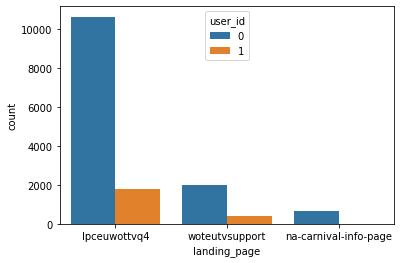

In [22]:
sns.countplot(x='landing_page', hue='user_id', data=data)

<AxesSubplot:xlabel='user_id', ylabel='count'>

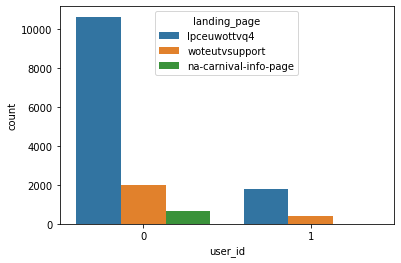

In [23]:
sns.countplot(x='user_id', hue='landing_page', data=data)

<AxesSubplot:xlabel='os_name', ylabel='count'>

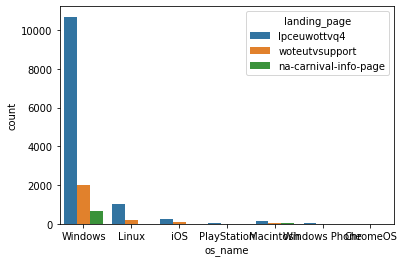

In [24]:
sns.countplot(x='os_name', hue='landing_page', data=data)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15466 entries, 0 to 15465
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   landing_page     15466 non-null  object        
 1   user_id          15466 non-null  int8          
 2   show_date_time   15466 non-null  datetime64[ns]
 3   browser_version  14698 non-null  object        
 4   browser          15342 non-null  object        
 5   os_name          15188 non-null  object        
 6   country          15466 non-null  object        
 7   weekday          15466 non-null  int64         
 8   hour             15466 non-null  int64         
dtypes: datetime64[ns](1), int64(2), int8(1), object(5)
memory usage: 981.9+ KB


In [26]:
data = data.fillna('other')
#data['browser'] = data['browser'].astype(str) + ' ' + data['browser_version'].astype(str)
data = data.drop(columns=['show_date_time', 'browser_version'])

In [27]:
X = data.drop('user_id', axis=1)
y = data['user_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
y

0        0
1        0
2        0
3        0
4        0
        ..
15461    1
15462    0
15463    0
15464    1
15465    0
Name: user_id, Length: 15466, dtype: int8

In [29]:
X

,landing_page,browser,os_name,country,weekday,hour
0,lpceuwottvq4,Chrome,Windows,CZ,6,0
1,lpceuwottvq4,AndroidBrowser,Linux,DE,6,0
2,lpceuwottvq4,Microsoft Internet Explorer,Windows,GB,6,0
3,lpceuwottvq4,Chrome,Windows,PL,6,0
4,lpceuwottvq4,Microsoft Internet Explorer,Windows,FR,6,0
...,...,...,...,...,...,...
15461,lpceuwottvq4,Firefox,Windows,DE,5,22
15462,na-carnival-info-page,Chrome,Windows,TR,5,23
15463,lpceuwottvq4,Opera,Windows,EU,5,23
15464,lpceuwottvq4,Chrome,Windows,TR,5,23


In [30]:
categories = ['landing_page', 'browser', 'os_name', 'country']

In [31]:
cb = CatBoostClassifier(
    iterations = 1000,
    learning_rate = 0.02,
    depth = 6,
    l2_leaf_reg = 8,
    loss_function='CrossEntropy',
    eval_metric = 'AUC',
    cat_features = categories, 
    #auto_class_weights='Balanced',
    random_state=42,
    )

In [32]:
cb.fit(X_train, y_train, 
                use_best_model=True, 
                eval_set=(X_test, y_test),
                logging_level = 'Verbose',
                cat_features=categories,
                )

0:	test: 0.5201284	best: 0.5201284 (0)	total: 62.6ms	remaining: 1m 2s
1:	test: 0.5195308	best: 0.5201284 (0)	total: 66.6ms	remaining: 33.2s
2:	test: 0.5464285	best: 0.5464285 (2)	total: 76.5ms	remaining: 25.4s
3:	test: 0.5476738	best: 0.5476738 (3)	total: 79.8ms	remaining: 19.9s
4:	test: 0.5476738	best: 0.5476738 (3)	total: 82ms	remaining: 16.3s
5:	test: 0.5534522	best: 0.5534522 (5)	total: 85.8ms	remaining: 14.2s
6:	test: 0.5534540	best: 0.5534540 (6)	total: 90.2ms	remaining: 12.8s
7:	test: 0.5540691	best: 0.5540691 (7)	total: 93.7ms	remaining: 11.6s
8:	test: 0.5541403	best: 0.5541403 (8)	total: 97ms	remaining: 10.7s
9:	test: 0.5528761	best: 0.5541403 (8)	total: 102ms	remaining: 10.1s
10:	test: 0.5835596	best: 0.5835596 (10)	total: 105ms	remaining: 9.42s
11:	test: 0.5835159	best: 0.5835596 (10)	total: 107ms	remaining: 8.84s
12:	test: 0.5856968	best: 0.5856968 (12)	total: 110ms	remaining: 8.36s
13:	test: 0.5856968	best: 0.5856968 (12)	total: 113ms	remaining: 7.94s
14:	test: 0.5863068	b

154:	test: 0.6967788	best: 0.6969341 (152)	total: 651ms	remaining: 3.55s
155:	test: 0.6968320	best: 0.6969341 (152)	total: 656ms	remaining: 3.55s
156:	test: 0.6968131	best: 0.6969341 (152)	total: 661ms	remaining: 3.55s
157:	test: 0.6968131	best: 0.6969341 (152)	total: 663ms	remaining: 3.53s
158:	test: 0.6969443	best: 0.6969443 (158)	total: 668ms	remaining: 3.54s
159:	test: 0.6966295	best: 0.6969443 (158)	total: 673ms	remaining: 3.53s
160:	test: 0.6966775	best: 0.6969443 (158)	total: 678ms	remaining: 3.53s
161:	test: 0.6967204	best: 0.6969443 (158)	total: 682ms	remaining: 3.53s
162:	test: 0.6966973	best: 0.6969443 (158)	total: 686ms	remaining: 3.52s
163:	test: 0.6966955	best: 0.6969443 (158)	total: 691ms	remaining: 3.52s
164:	test: 0.6966278	best: 0.6969443 (158)	total: 694ms	remaining: 3.51s
165:	test: 0.6966526	best: 0.6969443 (158)	total: 697ms	remaining: 3.5s
166:	test: 0.6965797	best: 0.6969443 (158)	total: 702ms	remaining: 3.5s
167:	test: 0.6965934	best: 0.6969443 (158)	total: 706

293:	test: 0.6973785	best: 0.6975715 (262)	total: 1.24s	remaining: 2.99s
294:	test: 0.6974034	best: 0.6975715 (262)	total: 1.25s	remaining: 2.98s
295:	test: 0.6974385	best: 0.6975715 (262)	total: 1.25s	remaining: 2.98s
296:	test: 0.6974385	best: 0.6975715 (262)	total: 1.25s	remaining: 2.97s
297:	test: 0.6975647	best: 0.6975715 (262)	total: 1.26s	remaining: 2.96s
298:	test: 0.6975132	best: 0.6975715 (262)	total: 1.26s	remaining: 2.96s
299:	test: 0.6975775	best: 0.6975775 (299)	total: 1.27s	remaining: 2.96s
300:	test: 0.6975681	best: 0.6975775 (299)	total: 1.27s	remaining: 2.96s
301:	test: 0.6975681	best: 0.6975775 (299)	total: 1.27s	remaining: 2.94s
302:	test: 0.6975063	best: 0.6975775 (299)	total: 1.28s	remaining: 2.94s
303:	test: 0.6974746	best: 0.6975775 (299)	total: 1.28s	remaining: 2.94s
304:	test: 0.6975689	best: 0.6975775 (299)	total: 1.29s	remaining: 2.94s
305:	test: 0.6975895	best: 0.6975895 (305)	total: 1.29s	remaining: 2.93s
306:	test: 0.6974900	best: 0.6975895 (305)	total: 1

436:	test: 0.6984170	best: 0.6984685 (429)	total: 1.85s	remaining: 2.38s
437:	test: 0.6984823	best: 0.6984823 (437)	total: 1.85s	remaining: 2.37s
438:	test: 0.6984977	best: 0.6984977 (438)	total: 1.86s	remaining: 2.37s
439:	test: 0.6985011	best: 0.6985011 (439)	total: 1.86s	remaining: 2.37s
440:	test: 0.6985011	best: 0.6985011 (439)	total: 1.86s	remaining: 2.36s
441:	test: 0.6985046	best: 0.6985046 (441)	total: 1.87s	remaining: 2.36s
442:	test: 0.6985569	best: 0.6985569 (442)	total: 1.87s	remaining: 2.35s
443:	test: 0.6984608	best: 0.6985569 (442)	total: 1.88s	remaining: 2.35s
444:	test: 0.6985226	best: 0.6985569 (442)	total: 1.88s	remaining: 2.35s
445:	test: 0.6985372	best: 0.6985569 (442)	total: 1.88s	remaining: 2.34s
446:	test: 0.6985183	best: 0.6985569 (442)	total: 1.89s	remaining: 2.34s
447:	test: 0.6985269	best: 0.6985569 (442)	total: 1.89s	remaining: 2.33s
448:	test: 0.6985466	best: 0.6985569 (442)	total: 1.9s	remaining: 2.33s
449:	test: 0.6985663	best: 0.6985663 (449)	total: 1.

573:	test: 0.6993205	best: 0.6994123 (504)	total: 2.45s	remaining: 1.82s
574:	test: 0.6993033	best: 0.6994123 (504)	total: 2.45s	remaining: 1.81s
575:	test: 0.6992750	best: 0.6994123 (504)	total: 2.46s	remaining: 1.81s
576:	test: 0.6992115	best: 0.6994123 (504)	total: 2.46s	remaining: 1.81s
577:	test: 0.6991944	best: 0.6994123 (504)	total: 2.47s	remaining: 1.8s
578:	test: 0.6991781	best: 0.6994123 (504)	total: 2.48s	remaining: 1.8s
579:	test: 0.6991866	best: 0.6994123 (504)	total: 2.48s	remaining: 1.79s
580:	test: 0.6991841	best: 0.6994123 (504)	total: 2.48s	remaining: 1.79s
581:	test: 0.6991609	best: 0.6994123 (504)	total: 2.49s	remaining: 1.79s
582:	test: 0.6991446	best: 0.6994123 (504)	total: 2.49s	remaining: 1.78s
583:	test: 0.6991789	best: 0.6994123 (504)	total: 2.5s	remaining: 1.78s
584:	test: 0.6992742	best: 0.6994123 (504)	total: 2.5s	remaining: 1.77s
585:	test: 0.6992690	best: 0.6994123 (504)	total: 2.5s	remaining: 1.77s
586:	test: 0.6993522	best: 0.6994123 (504)	total: 2.51s	

709:	test: 0.7004290	best: 0.7006452 (702)	total: 3.05s	remaining: 1.25s
710:	test: 0.7004153	best: 0.7006452 (702)	total: 3.06s	remaining: 1.24s
711:	test: 0.7004187	best: 0.7006452 (702)	total: 3.07s	remaining: 1.24s
712:	test: 0.7004461	best: 0.7006452 (702)	total: 3.07s	remaining: 1.24s
713:	test: 0.7004341	best: 0.7006452 (702)	total: 3.07s	remaining: 1.23s
714:	test: 0.7005062	best: 0.7006452 (702)	total: 3.08s	remaining: 1.23s
715:	test: 0.7004976	best: 0.7006452 (702)	total: 3.08s	remaining: 1.22s
716:	test: 0.7002488	best: 0.7006452 (702)	total: 3.09s	remaining: 1.22s
717:	test: 0.7002883	best: 0.7006452 (702)	total: 3.09s	remaining: 1.21s
718:	test: 0.7002960	best: 0.7006452 (702)	total: 3.1s	remaining: 1.21s
719:	test: 0.7003011	best: 0.7006452 (702)	total: 3.1s	remaining: 1.21s
720:	test: 0.7001484	best: 0.7006452 (702)	total: 3.1s	remaining: 1.2s
721:	test: 0.7001501	best: 0.7006452 (702)	total: 3.11s	remaining: 1.2s
722:	test: 0.7001673	best: 0.7006452 (702)	total: 3.11s	

842:	test: 0.7006177	best: 0.7006452 (702)	total: 3.66s	remaining: 681ms
843:	test: 0.7006203	best: 0.7006452 (702)	total: 3.66s	remaining: 677ms
844:	test: 0.7006109	best: 0.7006452 (702)	total: 3.67s	remaining: 672ms
845:	test: 0.7006006	best: 0.7006452 (702)	total: 3.67s	remaining: 668ms
846:	test: 0.7005997	best: 0.7006452 (702)	total: 3.67s	remaining: 664ms
847:	test: 0.7006169	best: 0.7006452 (702)	total: 3.68s	remaining: 660ms
848:	test: 0.7006195	best: 0.7006452 (702)	total: 3.69s	remaining: 655ms
849:	test: 0.7006246	best: 0.7006452 (702)	total: 3.69s	remaining: 651ms
850:	test: 0.7006032	best: 0.7006452 (702)	total: 3.69s	remaining: 647ms
851:	test: 0.7006032	best: 0.7006452 (702)	total: 3.7s	remaining: 642ms
852:	test: 0.7005774	best: 0.7006452 (702)	total: 3.7s	remaining: 638ms
853:	test: 0.7004770	best: 0.7006452 (702)	total: 3.71s	remaining: 634ms
854:	test: 0.7004642	best: 0.7006452 (702)	total: 3.71s	remaining: 630ms
855:	test: 0.7004281	best: 0.7006452 (702)	total: 3.7

975:	test: 0.7003011	best: 0.7006452 (702)	total: 4.25s	remaining: 105ms
976:	test: 0.7002540	best: 0.7006452 (702)	total: 4.26s	remaining: 100ms
977:	test: 0.7002754	best: 0.7006452 (702)	total: 4.27s	remaining: 96ms
978:	test: 0.7002643	best: 0.7006452 (702)	total: 4.27s	remaining: 91.6ms
979:	test: 0.7003346	best: 0.7006452 (702)	total: 4.28s	remaining: 87.3ms
980:	test: 0.7003277	best: 0.7006452 (702)	total: 4.28s	remaining: 82.9ms
981:	test: 0.7003183	best: 0.7006452 (702)	total: 4.29s	remaining: 78.6ms
982:	test: 0.7002368	best: 0.7006452 (702)	total: 4.29s	remaining: 74.2ms
983:	test: 0.7001184	best: 0.7006452 (702)	total: 4.3s	remaining: 69.9ms
984:	test: 0.7002334	best: 0.7006452 (702)	total: 4.3s	remaining: 65.5ms
985:	test: 0.7002462	best: 0.7006452 (702)	total: 4.31s	remaining: 61.2ms
986:	test: 0.7002823	best: 0.7006452 (702)	total: 4.31s	remaining: 56.8ms
987:	test: 0.7002960	best: 0.7006452 (702)	total: 4.32s	remaining: 52.4ms
988:	test: 0.7002600	best: 0.7006452 (702)	t

In [33]:
roc_auc_cb = roc_auc_score(y_test, cb.predict_proba(X_test)[:, 1])
print(f"roc_auc для модели CatBoost на тестовой выборке: {roc_auc_cb:.3f}")
accuracy_cb = accuracy_score(y_test, cb.predict(X_test))
print(f"accuracy для модели CatBoost на тестовой выборке: {accuracy_cb:.3f}")

roc_auc для модели CatBoost на тестовой выборке: 0.701
accuracy для модели CatBoost на тестовой выборке: 0.858


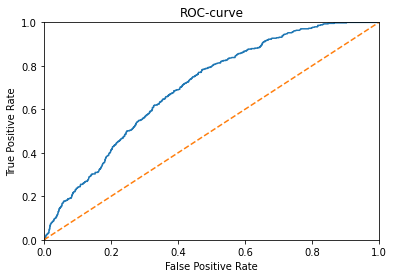

In [34]:
def make_roc_curve(y_test, pred_test):
    fpr, tpr, thresholds = roc_curve(y_test, pred_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve')
    plt.show()
    
make_roc_curve(y_test, cb.predict_proba(X_test)[:, 1])

In [35]:
feat_import = pd.DataFrame(data = {'feature': X_train.columns, 'percent': cb.feature_importances_})
feat_import.sort_values('percent', ascending=False).reset_index(drop=True)

,feature,percent
0,country,34.518011
1,landing_page,23.240213
2,os_name,17.949397
3,browser,11.507582
4,hour,7.320295
5,weekday,5.464502


In [36]:
cb_proba = cb.predict_proba(X_test)[:, 1]
df_proba = pd.DataFrame(data = {'cb_proba': cb_proba})

In [37]:
X_test

,landing_page,browser,os_name,country,weekday,hour
3822,lpceuwottvq4,Chrome,Windows,PL,5,16
2750,lpceuwottvq4,Chrome,Windows,RO,3,19
12294,woteutvsupport,Firefox,Windows,HR,6,13
9652,lpceuwottvq4,Firefox,Windows,DE,1,17
12769,lpceuwottvq4,Microsoft Internet Explorer,Windows,DE,0,13
...,...,...,...,...,...,...
11669,lpceuwottvq4,Microsoft Internet Explorer,Windows,PL,5,13
1417,lpceuwottvq4,Firefox,Windows,FR,1,14
1157,lpceuwottvq4,Microsoft Internet Explorer,Windows,AT,0,20
3654,woteutvsupport,Opera,Windows,HU,5,13


In [38]:
landings = ['lpceuwottvq4', 'na-carnival-info-page', 'woteutvsupport']

In [39]:
def ft_proba(data, X_test):
    test = X_test.copy()
    for l in landings:
        test['landing_page'] = l
        data[l] = cb.predict_proba(test)[:, 1]
    return data

In [40]:
df_proba = ft_proba(df_proba, X_test)

In [41]:
df_proba['best'] = df_proba.values.max(1)
df_proba['new_landing_page'] = df_proba[landings].idxmax(axis="columns")
df_proba

,cb_proba,lpceuwottvq4,na-carnival-info-page,woteutvsupport,best,new_landing_page
0,0.218483,0.218483,0.024006,0.210429,0.218483,lpceuwottvq4
1,0.281130,0.281130,0.024382,0.176867,0.281130,lpceuwottvq4
2,0.246425,0.204666,0.022873,0.246425,0.246425,woteutvsupport
3,0.115938,0.115938,0.010454,0.104192,0.115938,lpceuwottvq4
4,0.079590,0.079590,0.011142,0.077114,0.079590,lpceuwottvq4
...,...,...,...,...,...,...
3089,0.156745,0.156745,0.018543,0.132189,0.156745,lpceuwottvq4
3090,0.199979,0.199979,0.022954,0.173616,0.199979,lpceuwottvq4
3091,0.091828,0.091828,0.010323,0.096032,0.096032,woteutvsupport
3092,0.249836,0.272976,0.040880,0.249836,0.272976,lpceuwottvq4


In [42]:
sum(df_proba['best'] > df_proba['cb_proba'])

1128

Примерно в 1/3 случаях можно было применить другой лэндинг, с которого вероятнось регистрации пользователя была бы выше.
Ниже в таблице привидены параметры, при которых стоит выбрать тот или иной вид лэндинга.

In [43]:
X_test.reset_index(inplace=True)
X_test['new_landing_page'] = df_proba['new_landing_page']

In [44]:
X_test

,index,landing_page,browser,os_name,country,weekday,hour,new_landing_page
0,3822,lpceuwottvq4,Chrome,Windows,PL,5,16,lpceuwottvq4
1,2750,lpceuwottvq4,Chrome,Windows,RO,3,19,lpceuwottvq4
2,12294,woteutvsupport,Firefox,Windows,HR,6,13,woteutvsupport
3,9652,lpceuwottvq4,Firefox,Windows,DE,1,17,lpceuwottvq4
4,12769,lpceuwottvq4,Microsoft Internet Explorer,Windows,DE,0,13,lpceuwottvq4
...,...,...,...,...,...,...,...,...
3089,11669,lpceuwottvq4,Microsoft Internet Explorer,Windows,PL,5,13,lpceuwottvq4
3090,1417,lpceuwottvq4,Firefox,Windows,FR,1,14,lpceuwottvq4
3091,1157,lpceuwottvq4,Microsoft Internet Explorer,Windows,AT,0,20,woteutvsupport
3092,3654,woteutvsupport,Opera,Windows,HU,5,13,lpceuwottvq4


Дальше были идеи сделать еще одну модель классификации, где в качестве целевой метрики была бы new_landing_page, на выборке  - только тех, кто зарегистрировался. Но кажется это еще больше отдаляет решение от реальности. 
